In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plot
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
def do_cross_validation(X, y, model):
    regressor_name = model.__class__.__name__
    fold = KFold(n_splits=10, shuffle=True, random_state=0)
    scores_on_this_split = cross_val_score(estimator=model, X=X,y=y, cv=fold, scoring='r2')
    scores_on_this_split = np.round(scores_on_this_split * 100, 2)
    score = scores_on_this_split.mean()
    print(score)
    return score


In [3]:
def show_correlation(df):
    corr = df.corr() * 100

    # Select upper triangle of correlation matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    plot.subplots(figsize=(25, 22))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                linewidths=1, cbar_kws={"shrink": .7}, annot=True,
                fmt=".2f")


# New dataset

In [4]:
df3 = pd.read_csv('flats3.csv')

positive_impact = ['мебель', 'luxury','видеонаблюдение']
negative_impact  = ['studio', 'rush','dorm']
geo_features = ['metro','num_of_stops_1km','num_of_shops_1km','num_of_kindergarden_1km',
                'num_of_medical_1km','center_distance']
flat_features=['total_area', 'repair','balcony_y', 'walls_y','district_y', 'age_y']
competitors_features = ['distance_200m', 'same_house']

cols = ['cost']
cols+=flat_features
cols+=geo_features
cols+=competitors_features
cols+=positive_impact
cols+=negative_impact
df3 = df3[cols]

In [5]:
df3['impact'] = 0
for i, row in df3.iterrows():
    impact = 0
    for positive in  positive_impact:
        if row[positive]:
             impact+=1
    for negative in  negative_impact:
        if row[negative]:
            impact-=1
    
    df3.at[i, 'impact'] = impact
    

In [6]:
y = df3.cost
X = df3.drop(columns=['cost'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

## Naive aproach

38.19799999999999
59.330000000000005
68.801
75.989
81.51299999999999
85.22200000000001
87.706
89.409
90.46900000000001
91.172
91.588
91.66600000000001
91.88699999999999
92.08500000000001
91.905
91.976
92.067
91.959
92.01999999999998


Text(0.5, 1.0, 'Max score - 92.08500000000001\nDepth 14.0 ')

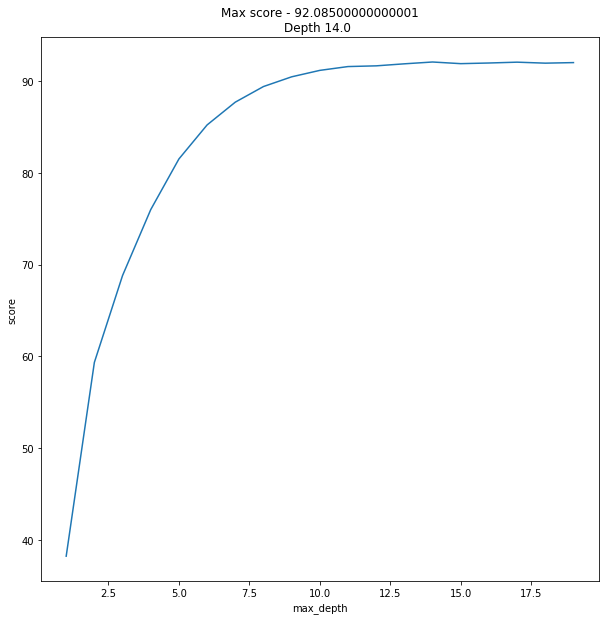

In [7]:
data = []
max_features =  int(X.shape[1]/2)
for x in range(1,20):
    regressor = RandomForestRegressor(verbose=0,
                                      n_estimators=128,
                                      max_features=max_features, 
                                      max_depth=x,
                                      random_state=42)
   
    model =   regressor.fit(X_train, y_train)
    score = do_cross_validation(X, y, model)
    data.append({'max_depth':x,'score':score})
data = pd.DataFrame(data)
f, ax = plot.subplots(figsize=(10, 10))
sns.lineplot(x="max_depth", y="score", data=data)
max_result = data.loc[data['score'].idxmax()]

ax.set_title(f'Max score - {max_result.score}\nDepth {max_result.max_depth} ')

In [8]:
regressor = RandomForestRegressor(random_state=42,
                                  max_depth=max_result.max_depth,
                                  n_estimators=128,
                                  max_features=max_features)
rf3 =   regressor.fit(X_train, y_train)


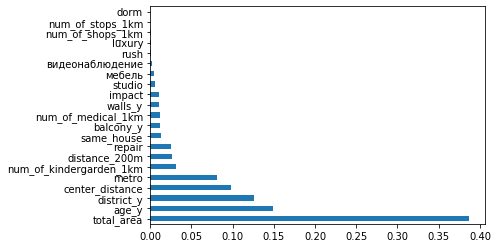

In [9]:
feat_importances = pd.Series(rf3.feature_importances_, index=X.columns)
feat_importances.nlargest(X.shape[1]).plot(kind='barh')

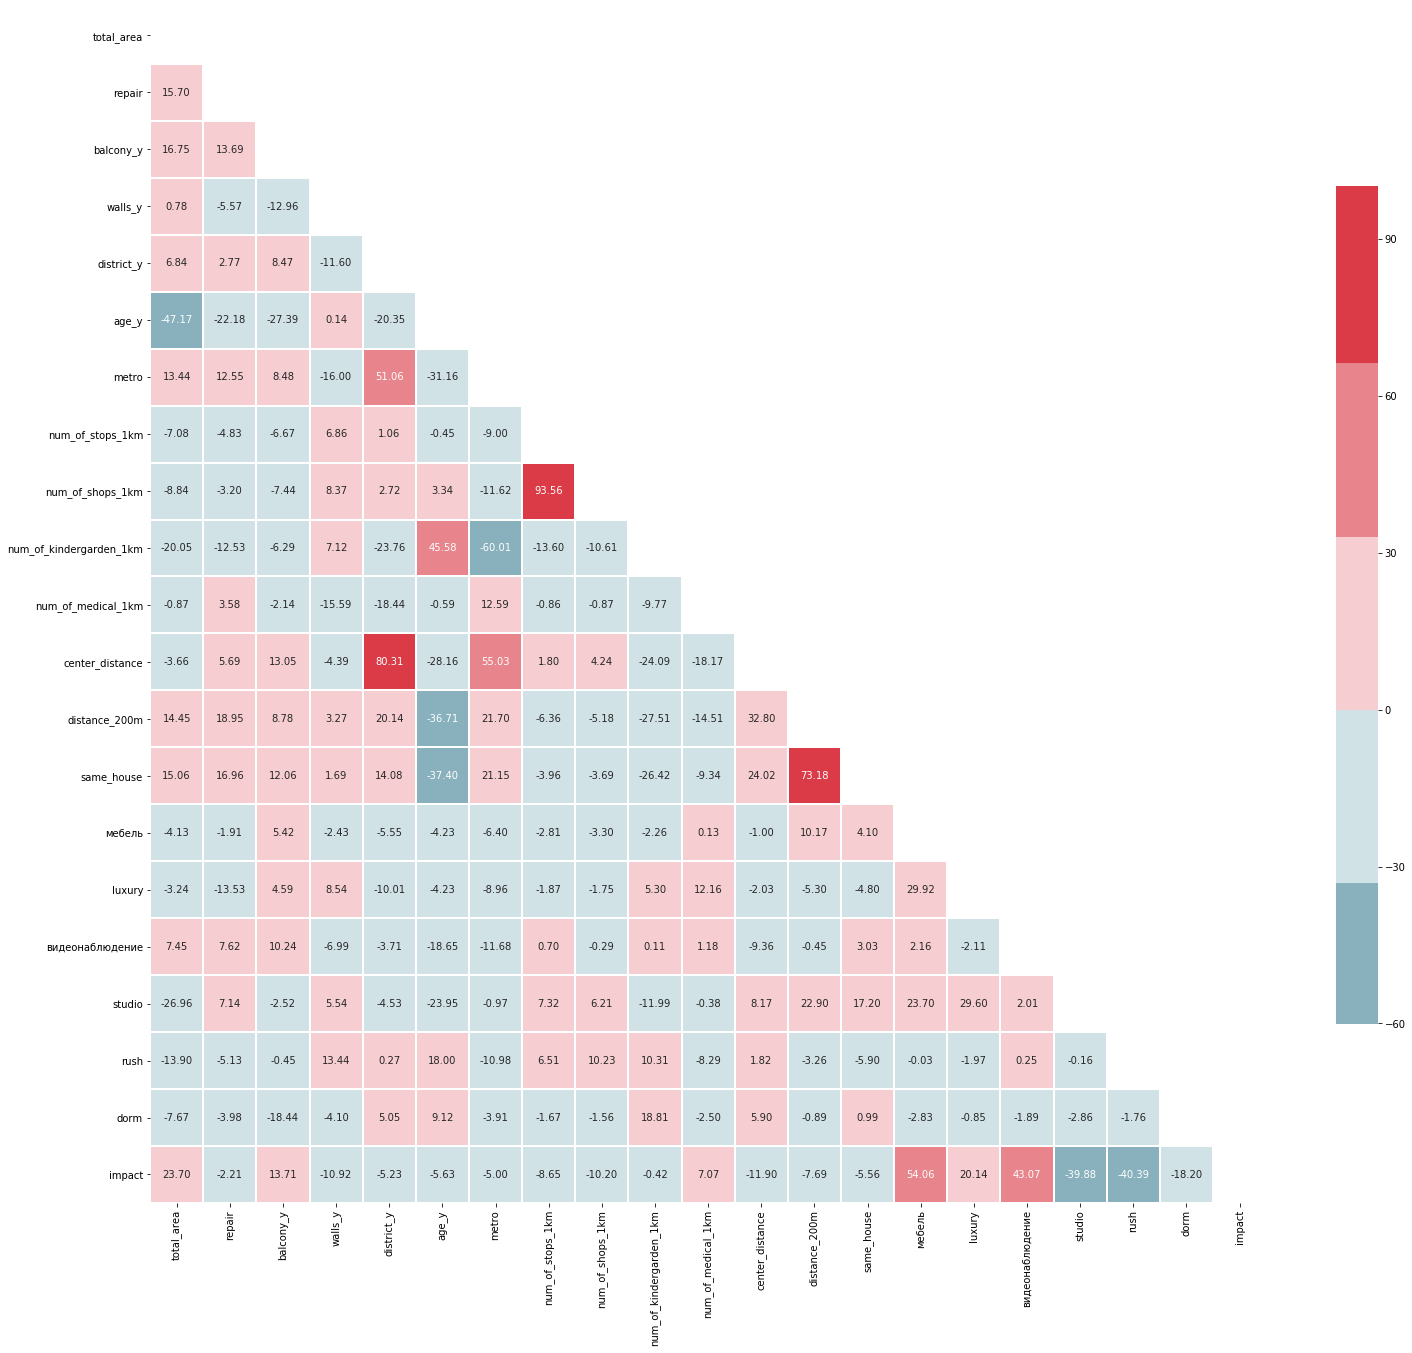

In [10]:
show_correlation(X_test)

## Heavy tools

91.515
92.11200000000001
92.678
92.61
92.571
92.52900000000001
92.25


Text(0.5, 1.0, 'Max score-92.678\nDepth 5.0 ')

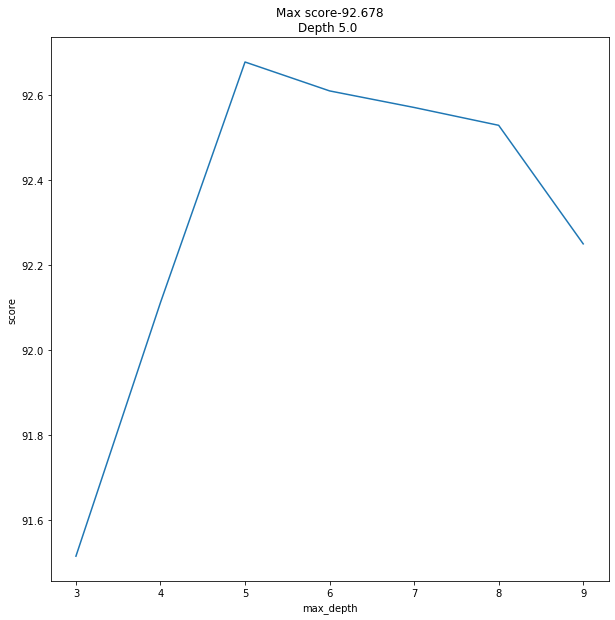

In [11]:
from xgboost import XGBRegressor,plot_importance
data = []
for x in range(3,10):
    regressor = XGBRegressor(verbose=0,
                             reg_lambda=10,
                             n_estimators=1000,     
                             objective='reg:squarederror', 
                             max_depth=x,
                             random_state=42)
   
    model =   regressor.fit(X_train, y_train)
    score = do_cross_validation(X, y, model)
    data.append({'max_depth':x,'score':score})
data = pd.DataFrame(data)
f, ax = plot.subplots(figsize=(10, 10))
sns.lineplot(x="max_depth", y="score", data=data)
max_result = data.loc[data['score'].idxmax()]

ax.set_title(f'Max score-{max_result.score}\nDepth {max_result.max_depth} ')

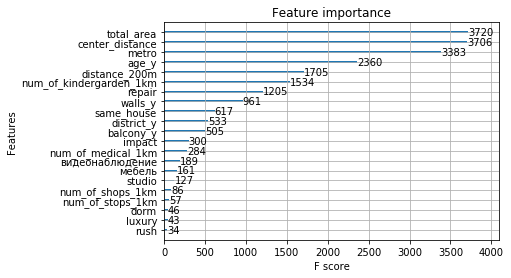

In [12]:
regressor = XGBRegressor(verbose=0,
                         reg_lambda=10,
                         n_estimators=1000,   
                         objective='reg:squarederror',   
                         max_depth=int(max_result.max_depth),
                         random_state=42)
xgb =   regressor.fit(X_train, y_train)
plot_importance(xgb.get_booster())